# Sentiment Analysis with IndoBERT Fine-tuning and IndoNLU SmSA Dataset

## Import Libraries

In [1]:
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report 
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import evaluate
import torch
import os
import datasets

import pandas as pd
import random
from IPython.display import display, HTML


# MPS checking
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

tensor([1.], device='mps:0')


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import transformers

print(transformers.__version__)

4.39.0.dev0


In [4]:
MODEL_CHECKPOINT = "indobenchmark/indobert-base-p1"
MODEL_DIR = "IndoBERT-Sentiment-Analysis"

LEARNING_RATE = 2e-5
BATCH_SIZE = 6
EPOCHS = 5

## Load Dataset

In [5]:
dataset = load_dataset("indonlp/indonlu", "smsa")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 11000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 500
    })
})

In [6]:
dataset["train"][0]

{'text': 'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !',
 'label': 0}

In [7]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

In [8]:
def show_random_elements(dataset, num_examples):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(dataset["train"], 10)

,text,label
0,"hmmm mantap coffee nya , pemandangan nya keren , ayo minum kopi di sini , terima kasih mbak della servis nya top deh :::: suka sekali pelayanan yang begitu rendah hati nya",positive
1,"sabtu kemarin saya mampir ke yagami ramen rumah nama nya sekarang sudah ganti loh hihi , konsep nya bikin betah deh duduk manis di sana . disediakan komik juga loh di sini , sambil menunggu pesanan sambil baca komik jadi nya tidak bosan : d padahal makanan yang aku pesan datang nya juga tidak lama lama banget kok cuma ya jadi asik baca komik aja gitu sambil makan ramen .",positive
2,"lebih kesal saya wi , 2014 tidak punya presiden ada nya cuma petugas partai",negative
3,"makanan yang tersaji di restoran ini mempunyai selera yang sangat tinggi , begitupun dengan kualitas makanan nya yang sudah tidak diragukan lagi , restoran ini adalah restoran langganan keluarga saya , setiap kali ada waktu berkumpul bersama keluarga pasti menyempatkan waktu untuk makan malam di restoran ini , makanan yang paling memikat hati saya adalah steak , karena ini beda dari steak yang lainnya , steak nya mempunyai ukuran yang pas .",positive
4,berita indonesia : presiden jokowi : denyut nadi perekonomian ada di pasar rakyat,neutral
5,"ayam kung po paling terbaik . pelayanan cepat , makanan minuman semua sedap . sudah kali ke dua datang makan ta wan . dan ke depan nya pasti bakal ke sini lagi .",positive
6,"salah satu restoran yang saya rekomendasikan di trans studio mal trans stusio mal , cocok untuk makan siang / malam bersama keluarga . makanan nya sehat , bergizi , segar dan memiliki cita rasa yang nikmat . menu nya memang mirip dengan hidangan yang disajikan di resto sejenis .",positive
7,"berlibur pada saat lebaran membuat kami kesusahan mencari hotel , pada akhirnya kami menginap di hyper inn paskal , dan pada saat malam hari kami berjalan kaki dari hotel untuk mencari makan di paskal makanan pasar , tempat nya sangat ramai dan banyak pilihan makanan yang dilengkapi dengan live music",positive
8,"pak presiden pecat saja anis , mending diusut kasus korupsi - orupsi nya",negative
9,kemarin mereka mendaftar beasiswa djarum,neutral


## Preprocessing

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [12]:
tokenized = dataset.map(preprocess_function, batched=True)
tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [13]:
id2label = {0: "POSITIVE", 1: "NEUTRAL", 2: "NEGATIVE"}
label2id = {"POSITIVE": 0, "NEUTRAL": 1, "NEGATIVE": 2}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3, id2label=id2label, label2id=label2id)

/Users/crypter70/opt/anaconda3/envs/pytorch-gpu/lib/python3.11/site-packages/torch/_utils.py:830: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = metrics.accuracy_score(labels, predictions)
    f1_score = metrics.f1_score(labels, predictions, average='weighted')
    
    return {"accuracy": accuracy, "f1_score": f1_score}

## Fine-tuning Pre-trained Model

In [15]:
training_args = TrainingArguments(
    output_dir=MODEL_DIR,
    evaluation_strategy="steps",
    logging_strategy="steps",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Score
500,0.349900,0.239201,0.930952,0.931086
1000,0.318100,0.335398,0.917460,0.915798
1500,0.300100,0.296470,0.923810,0.924299
2000,0.253400,0.351336,0.922222,0.921771
2500,0.169200,0.265665,0.940476,0.939941
3000,0.154300,0.404573,0.919841,0.919069
3500,0.182700,0.279976,0.931746,0.931880
4000,0.106100,0.335177,0.938889,0.938853
4500,0.063900,0.403253,0.937302,0.936542
5000,0.070900,0.350776,0.936508,0.935998


Error during conversion: ValueError('Queue is full! Please try again.')


TrainOutput(global_step=9170, training_loss=0.1200256623514606, metrics={'train_runtime': 5440.4557, 'train_samples_per_second': 10.109, 'train_steps_per_second': 1.686, 'total_flos': 1957026295406196.0, 'train_loss': 0.1200256623514606, 'epoch': 5.0})

## Evaluate

In [16]:
trainer.evaluate()

{'eval_loss': 0.4220746159553528,
 'eval_accuracy': 0.9452380952380952,
 'eval_f1_score': 0.9451348992924798,
 'eval_runtime': 30.3562,
 'eval_samples_per_second': 41.507,
 'eval_steps_per_second': 6.918,
 'epoch': 5.0}

In [17]:
trainer.save_model(MODEL_DIR)

In [18]:
trainer.push_to_hub()

python3(84363) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/crypter70/IndoBERT-Sentiment-Analysis/commit/c1f49b81a457d40a6ee084ac73bdafd0e7eff6a2', commit_message='End of training', commit_description='', oid='c1f49b81a457d40a6ee084ac73bdafd0e7eff6a2', pr_url=None, pr_revision=None, pr_num=None)

In [19]:
predictions = trainer.predict(tokenized["test"])
predicted_labels = predictions.predictions.argmax(-1)
true_labels = tokenized["test"]["label"]

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1-score:", f1)

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.906
F1-score: 0.9010698039215687
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       208
           1       0.90      0.64      0.75        88
           2       0.90      0.98      0.94       204

    accuracy                           0.91       500
   macro avg       0.91      0.85      0.87       500
weighted avg       0.91      0.91      0.90       500



In [20]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[197,   6,   5],
       [ 16,  56,  16],
       [  4,   0, 200]])

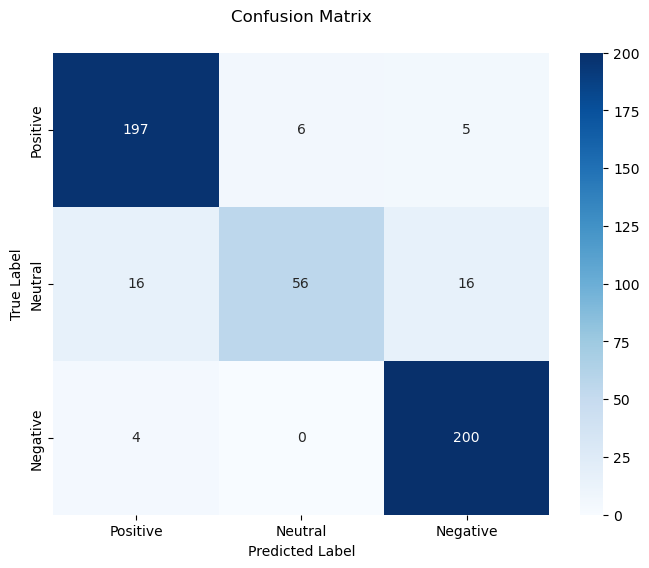

In [21]:
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix", y=1.05)

g = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Positive", "Neutral", "Negative"], 
            yticklabels=["Positive", "Neutral", "Negative"])

g.set(ylabel='True Label', xlabel='Predicted Label')
plt.show()

## Using Model with Pipeline

In [22]:
model_dir = MODEL_DIR
tokenizer_dir = MODEL_DIR

model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)

classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

### Positive Sentiment Testing

In [23]:
text = """
Doi asik bgt orangnya
"""

classifier(text)

[{'label': 'POSITIVE', 'score': 0.9999681711196899}]

### Neutral Sentiment Testing

In [24]:
text = """
Ada pengumuman nih gaiss, besok kegiatan kantor diliburkan
"""

classifier(text)

[{'label': 'NEUTRAL', 'score': 0.9999117851257324}]

### Negative Sentiment Testing

In [25]:
text = """
Kok gni sih kelakuannya
"""

classifier(text)

[{'label': 'NEGATIVE', 'score': 0.9999523162841797}]